# Heart Disease Classification with Tree-Based Models

This notebook demonstrates the use of various tree-based classifiers to predict heart disease. We'll explore Decision Trees, Random Forests, and Gradient Boosting (XGBoost), and compare their performance.

In [1]:
# Install required packages
!pip install -q kagglehub ydf xgboost

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import kagglehub
import os

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hiiamjeff","key":"a460655ddaf3b4bee8ac6d2b62811908"}'}

In [3]:
# Download dataset using kagglehub (no need for kaggle.json)
dataset_dir = kagglehub.dataset_download("redwankarimsony/heart-disease-data")
print("Files in dataset directory:", os.listdir(dataset_dir))

Files in dataset directory: ['heart_disease_uci.csv']


In [4]:
# Load the CSV data into a DataFrame
csv_file = os.path.join(dataset_dir, "heart_disease_uci.csv")
data = pd.read_csv(csv_file)
print("Columns:", data.columns.tolist())
data.head()

Columns: ['id', 'age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [5]:
# Display data info and check for missing values
print(data.info())
print(data.describe())
print("Missing values per column:\n", data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB
None
               id         age    trestbps        chol      thalch     oldpeak  \
count  920.000000  920.000000  861.000000  

In [6]:
# Fill missing values for numerical columns with median
for feature in ['trestbps', 'chol', 'thalch', 'oldpeak', 'ca']:
    if data[feature].isnull().any():
        data[feature].fillna(data[feature].median(), inplace=True)

# Fill missing values for categorical columns with mode
for feature in ['fbs', 'restecg', 'exang', 'slope', 'thal']:
    if data[feature].isnull().any():
        data[feature].fillna(data[feature].mode()[0], inplace=True)

<ipython-input-6-abe695728f17>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[feature].fillna(data[feature].median(), inplace=True)
<ipython-input-6-abe695728f17>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

In [7]:
# Encode categorical columns as integers
for col in data.select_dtypes(include='object').columns:
    data[col] = data[col].astype('category').cat.codes

In [8]:
# Ensure target column is named 'target'
if 'target' not in data.columns and 'num' in data.columns:
    data.rename(columns={'num': 'target'}, inplace=True)

In [9]:
# Remove unnecessary columns if present
for col in ['id', 'dataset']:
    if col in data.columns:
        data.drop(col, axis=1, inplace=True)

In [10]:
# Split features and target, then create train/test sets
X = data.drop('target', axis=1)
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Decision Tree Classifier

Train a Decision Tree and evaluate its performance.

In [11]:
# Decision Tree model training
dt_model = DecisionTreeClassifier(
    random_state=42, max_depth=6, min_samples_split=10
)
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, dt_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, dt_pred))
print("Classification Report:\n", classification_report(y_test, dt_pred))

Decision Tree Accuracy: 0.5108695652173914
Confusion Matrix:
 [[65  6  3  1  0]
 [17 21  9  7  0]
 [ 3 14  5  2  1]
 [ 8 12  1  3  2]
 [ 0  0  2  2  0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.87      0.77        75
           1       0.40      0.39      0.39        54
           2       0.25      0.20      0.22        25
           3       0.20      0.12      0.15        26
           4       0.00      0.00      0.00         4

    accuracy                           0.51       184
   macro avg       0.31      0.31      0.31       184
weighted avg       0.46      0.51      0.48       184



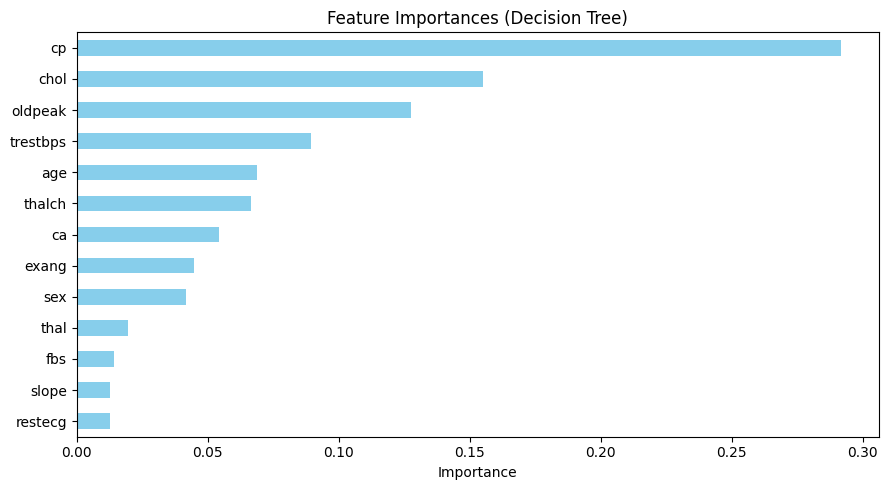

In [12]:
# Plot feature importances for Decision Tree
plt.figure(figsize=(9, 5))
importances = pd.Series(dt_model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', color='skyblue')
plt.title("Feature Importances (Decision Tree)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

## Random Forest Classifier

Train a Random Forest and evaluate its performance.

In [13]:
# Random Forest model training
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_pred))
print("Classification Report:\n", classification_report(y_test, rf_pred))

Random Forest Accuracy: 0.5597826086956522
Confusion Matrix:
 [[70  3  2  0  0]
 [21 26  2  5  0]
 [ 3 15  1  6  0]
 [ 5 13  2  6  0]
 [ 0  1  1  2  0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.93      0.80        75
           1       0.45      0.48      0.46        54
           2       0.12      0.04      0.06        25
           3       0.32      0.23      0.27        26
           4       0.00      0.00      0.00         4

    accuracy                           0.56       184
   macro avg       0.32      0.34      0.32       184
weighted avg       0.48      0.56      0.51       184



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## XGBoost Classifier

Train an XGBoost classifier and evaluate its performance.

In [14]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, xgb_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, xgb_pred))
print("Classification Report:\n", classification_report(y_test, xgb_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:18:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.5869565217391305
Confusion Matrix:
 [[68  5  2  0  0]
 [21 24  7  2  0]
 [ 4 10  7  4  0]
 [ 4 11  2  9  0]
 [ 0  2  0  2  0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.91      0.79        75
           1       0.46      0.44      0.45        54
           2       0.39      0.28      0.33        25
           3       0.53      0.35      0.42        26
           4       0.00      0.00      0.00         4

    accuracy                           0.59       184
   macro avg       0.42      0.40      0.40       184
weighted avg       0.55      0.59      0.56       184



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Model Comparison

Compare the accuracy of all three classifiers.

In [15]:
print("Summary of Model Accuracies:")
print(f"Decision Tree: {accuracy_score(y_test, dt_pred):.4f}")
print(f"Random Forest: {accuracy_score(y_test, rf_pred):.4f}")
print(f"XGBoost:      {accuracy_score(y_test, xgb_pred):.4f}")

Summary of Model Accuracies:
Decision Tree: 0.5109
Random Forest: 0.5598
XGBoost:      0.5870
